# Residuals Analysis


---
**License**

 Residuals Analisis

 Sun Dec 01 11:30:00 2024\
 Copyright  2024\
 Cinthia Nunes de Lima <cinthia.n.lima@uel.br> \ Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 Ascaso_Extended_Calibration\
 Copyright (C) 2024 Cinthia Nunes de Lima <cinthia.n.lima@uel.br>, Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Packages & Configs

In [1]:
import sys
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/Scripts")


#NumCosmo
from numcosmo_py import Ncm, Nc, GObject
from richness_mass_calib import create_richness_mass_calib

#Useful packages
import numpy as np
import math
from scipy import stats
import statsmodels.api as sm


from astropy.io import fits
from astropy.table import Table
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as gridspec
from matplotlib.gridspec import GridSpec

sys.path.insert(0, "/global/homes/c/cinlima/gcrcatalogs-new/gcr-catalogs")
import GCRCatalogs

%matplotlib inline

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

sys.path.insert(0, "global/homes/c/cinlima/clevar/clevar")

GCRCatalogs.set_root_dir_by_site("nersc")

#Calibration functions
from bdata import DataB
from fitting_model import FittingModel

### NumCosmo's Matching By Proximity

In [2]:
# mdata = Table.read('CatalogsMatching/test.fits')
# data = mdata[[len(m) > 0 for m in mdata['mass']]]

# mass_data= [m[0] for m in data['mass']]
# rich_data = [r for r in data['richness']]
# z_data = [z for z in data['z']]

# test_dt = Table([mass_data, rich_data, z_data], names=('mass', 'richness', 'redshift'))


### Data matched by ID

In [3]:
test_matchdata = Table.read('CatalogsMatching/match_ID.fits')

rich_data = test_matchdata["richness"]
z_data = test_matchdata["redshift"]
mass_data = test_matchdata["halo_mass"]
r_err_data = test_matchdata["richness_err"]

test_dt = Table([mass_data, rich_data, z_data, r_err_data], names=('mass', 'richness', 'redshift', 'richness_err'))


## Data

In [4]:
# test_matchdata = pd.read_csv('/global/homes/c/cinlima/MatchingCatalogs/match_catalog.csv',  sep = ';')

# rich_data = test_matchdata["richness"]
# z_data = test_matchdata["redshift_y"]
# mass_data = test_matchdata["halo_mass"]

# test_dt = Table([mass_data, rich_data, z_data], names=('mass', 'richness', 'redshift'))

In [5]:
test_dt = test_dt[test_dt['mass'] > 1.0e13]
test_dt = test_dt[np.logical_and(test_dt['redshift'] > 0, test_dt['redshift']< 3)]
test_dt = test_dt[np.logical_and(test_dt['richness'] > 0, test_dt['richness'] < 250)]

mass_dt = test_dt['mass']
red_dt = test_dt['redshift']
rich_dt = test_dt['richness']

print('Data')
print('\t\tMax \t\t\tMin')
print(f'Mass:\t\t{max(mass_dt):.2e}, \t\t{min(mass_dt):.2e}')
print(f'Redshift:\t{max(red_dt)}, \t{min(red_dt)}')
print(f'Richness:\t{max(rich_dt)}, \t{min(rich_dt)}')


dt_halos = test_dt

Data
		Max 			Min
Mass:		1.70e+15, 		1.00e+13
Redshift:	1.1998511783121595, 	0.07887901955195975
Richness:	233.71041870117188, 	5.007844924926758


## Models fit

### Training and test sets

In [6]:
# #Length of bins
# zl = 0.05
# ml = 0.05
# bd = DataB(test_dt, zl, ml)

In [7]:
# X = pd.DataFrame({'mass': list(dt_halos["mass"]), 'redshift': list(dt_halos["redshift"])})
# y = pd.DataFrame({'richness': list(dt_halos["richness"])})

# fm = FittingModel(dt_halos, zl, ml) #Fit object

# data_train = fm.cvdata(X,y)[0]
# data_test = fm.cvdata(X,y)[1]


### Bins


In [8]:
#Length of bins
zl = 0.05
ml = 0.05
bd = DataB(test_dt, zl, ml)
binned_mean = bd.get_bins_mean()
binned_std = bd.get_bins_std()

lnM_binned_mean = np.log(binned_mean['mass'])
z_binned_mean = binned_mean['redshift']
lnR_binned_mean = np.log(binned_mean['richness'])

print(f'Total bins in binned_mean: {len(bd.get_bins_mean())}')


Total bins in binned_mean: 1503


In [9]:
fm = FittingModel(dt_halos) #Fit object

### Ascaso Fit Params

Here we do the fitting of linear model parameters using training data in **data_train**. The model is:

\begin{equation}
    \left< \ln R | M, z \right> = \mu_0 + \mu_1 \ln\left( \frac{M}{M_0} \right) +  \mu_2\ln\left(\frac{1 + z}{1 + z_0}\right);
\end{equation}

$$\textbf{p}_{1} = \{\mu_0, \mu_1, \mu_2, \sigma_0, \sigma_1, \sigma_2\}. $$

$\textbf{p}_{1}$ is the vector with the linear model parameters.


In [10]:
ascaso = fm.run_fit('ascaso')

# lnR_mean_ascaso = fm.get_mean_model(ascaso, np.log(mass_dt),  red_dt)
# lnR_std_ascaso = fm.get_std_model(ascaso, np.log(mass_dt), red_dt)

lnR_mean_ascaso = fm.get_mean_model(ascaso, lnM_binned_mean,  z_binned_mean)
lnR_std_ascaso = fm.get_std_model(ascaso, lnM_binned_mean,  z_binned_mean)

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  3.19                [FREE]
#   -    mup1[01]:  0.868588963806504   [FREE]
#   -    mup2[02]: -0.304006137332276   [FREE]
#   - sigmap0[03]:  0.33                [FREE]
#   - sigmap1[04]: -0.0347435585522601  [FREE]
#   - sigmap2[05]:  0                   [FREE]
#   -     cut[06]:  100                 [FIXED]
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#........................................................

### Ext (ln(1+z)) Fit Params
Here we do the fitting of quadratic model parameters using training data in **data_train**. Dependence on $\ln (1 + z)$ is considered:

\begin{equation}\label{M_R_3}
\begin{split}
    \left<\ln R | M, z \right> = \mu_0 + 
    \mu_{M1} \ln\left( \frac{M}{M_0} \right) +
    \mu_{M2} (\ln\left(\frac{M}{M_0} \right))^2 +\\
    + \mu_{z1} \ln\left(\frac{1 + z}{1 + z_0}\right) +
    \mu_{z2} (\ln\left(\frac{1 + z}{1 + z_0}\right))^2 +\\
    + \mu_{Mz} \ln\left(\frac{1 + z}{1 + z_0}\right)\ln\left(\frac{M}{M_0} \right);
\end{split}
\end{equation}

$$\textbf{p}_{2} = \{\mu_0, \mu_{M1}, \mu_{M2}, \mu_{Z1}, \mu_{Z2}, \mu_{MZ}, \sigma_0, \sigma_{M1}, \sigma_{M2}, \sigma_{Z1}, \sigma_{Z2}, \sigma_{MZ} \}.$$

$\textbf{p}_{2}$ is the vector with the quadratic model parameters.


In [11]:
ext_ln1pz = fm.run_fit('ext_ln1pz')

# lnR_mean_ext_ln1pz = fm.get_mean_model(ext_ln1pz,  np.log(mass_dt),  red_dt)
# lnR_std_ext_ln1pz = fm.get_std_model(ext_ln1pz,  np.log(mass_dt),  red_dt)

lnR_mean_ext_ln1pz = fm.get_mean_model(ext_ln1pz,  lnM_binned_mean,  z_binned_mean)
lnR_std_ext_ln1pz = fm.get_std_model(ext_ln1pz, lnM_binned_mean,  z_binned_mean)


#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[09000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  3.19                [FREE]
#   -    muM1[01]:  0.868588963806504   [FREE]
#   -    muZ1[02]: -0.304006137332276   [FREE]
#   -    muM2[03]:  0                   [FREE]
#   -    muZ2[04]:  0                   [FREE]
#   -    muMZ[05]:  0                   [FREE]
#   -  sigma0[06]:  0.33                [FREE]
#   - sigmaM1[07]: -0.0347435585522601  [FREE]
#   - sigmaZ1[08]:  0                   [FREE]
#   - sigmaM2[09]:  0                   [FREE]
#   - sigmaZ2[10]:  0                   [FREE]
#   - sigmaMZ[11]:  0                   [FREE]
#   -      A0[12]:  0                   [FIX

<!-- ### Ext (z) Fit Params

Here we do the fitting of quadratic model parameters using training data in **data_train**. Dependence on $z$ is considered:

\begin{equation}\label{M_R_3}
\begin{split}
    \left<\ln R | M, z \right> = \mu_0 + 
    \mu_{M1} \ln\left( \frac{M}{M_0} \right) +
    \mu_{M2} (\ln\left(\frac{M}{M_0} \right))^2 +\\
    + \mu_{z1} \left(\frac{ z}{z_0}\right) +
    \mu_{z2} \left(\frac{z}{z_0}\right)^2 +
    \mu_{Mz} \left(\frac{z}{z_0}\right)\ln\left(\frac{M}{M_0} \right);
\end{split}
\end{equation}

$$\textbf{p}_{2} = \{\mu_0, \mu_{M1}, \mu_{M2}, \mu_{Z1}, \mu_{Z2}, \mu_{MZ}, \sigma_0, \sigma_{M1}, \sigma_{M2}, \sigma_{Z1}, \sigma_{Z2}, \sigma_{MZ} \}.$$ -->

## Errors

Text(0, 0.5, 'Residuals')

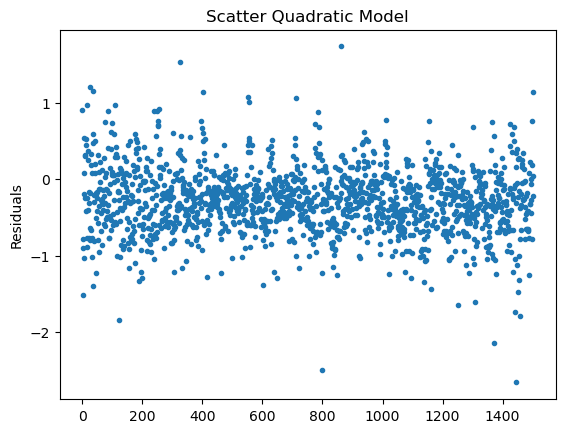

In [12]:
# Res = (lnR_mean_model - lnR_mean_bin) / Std_model

# residuals_ext = (lnR_mean_ext_ln1pz - np.log(rich_dt)) / lnR_std_ext_ln1pz
# residuals_asc = (lnR_mean_ascaso - np.log(rich_dt)) / lnR_std_ascaso

residuals_ext = (lnR_mean_ext_ln1pz - lnR_binned_mean) / lnR_std_ext_ln1pz
residuals_asc = (lnR_mean_ascaso - lnR_binned_mean) / lnR_std_ascaso


# plt.hist(residuals_ext)
# plt.title('Histogram Quadratic Model')

plt.plot(residuals_ext, '.')
plt.title('Scatter Quadratic Model')
# plt.xlabel('< ln R | M, z > Quadratic')
plt.ylabel('Residuals')

Text(0, 0.5, 'Residuals')

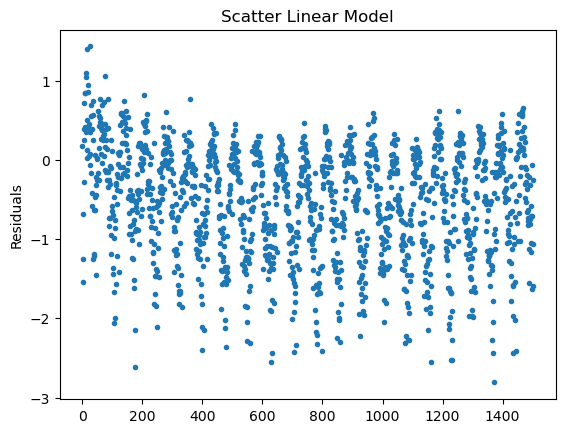

In [13]:
plt.plot( residuals_asc, '.')
# plt.scatter(range(len(residuals_asc)), residuals_asc)
plt.title('Scatter Linear Model')
# plt.xlabel('< ln R | M, z > ascaso ')
plt.ylabel('Residuals')

Text(0.5, 1.0, 'Histogram quadratic Model')

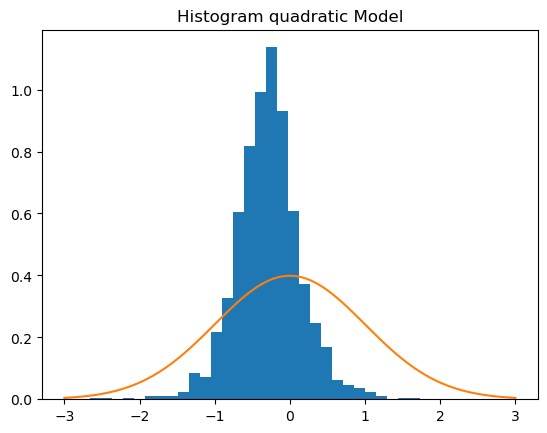

In [14]:
plt.hist(residuals_ext, bins=30, density=True)

x = np.linspace( -3, 3, 100)
plt.plot(x, stats.norm.pdf(x, 0, 1))

plt.title('Histogram quadratic Model')

Text(0.5, 1.0, 'Histogram Linear Model')

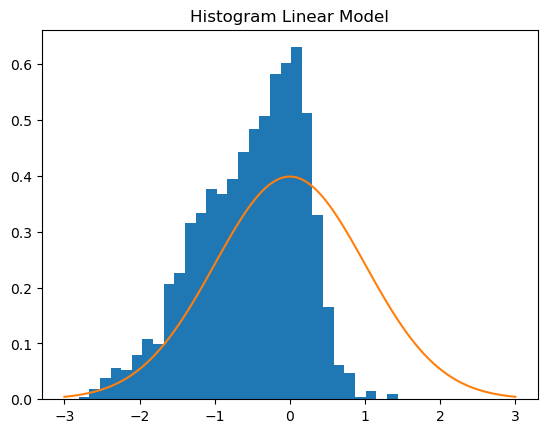

In [15]:
plt.hist(residuals_asc, bins=30, density=True)
plt.plot(x, stats.norm.pdf(x, 0, 1))
plt.title('Histogram Linear Model')

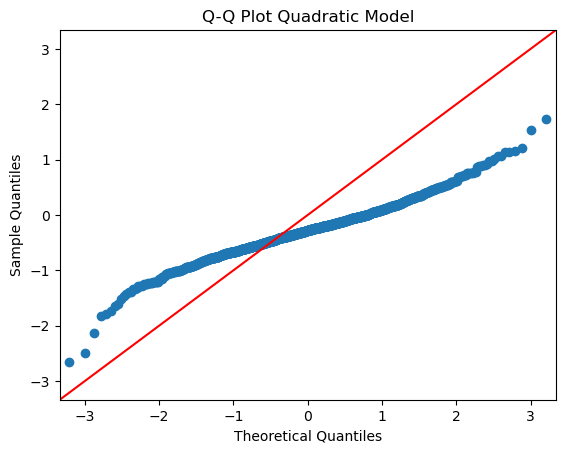

In [16]:
fig = sm.qqplot(residuals_ext, line='45')
plt.title('Q-Q Plot Quadratic Model')
plt.show()

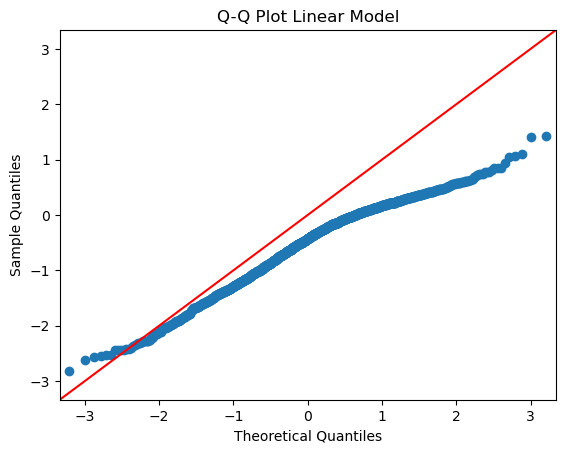

In [17]:
fig = sm.qqplot(residuals_asc, line='45')
plt.title('Q-Q Plot Linear Model')

plt.show()